## Our proposed model of `BART for Regression`

In [56]:
## Loading all the required libraries

import pandas as pd
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [48]:
## Loading the dataset and splitting the test dataset for later
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[:1803].reset_index( drop = True)
df.shape

(1803, 15)

In [5]:
## Customizing the last layers of the BART model based on our task
model_name = "facebook/bart-large-cnn"  
class BartForRegression(torch.nn.Module):
    def __init__(self):
        super(BartForRegression, self).__init__()
        self.bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
        self.dropout = torch.nn.Dropout(0.1)
        self.regression_head = torch.nn.Linear(self.bart_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_state = outputs.decoder_hidden_states[-1]
        regression_output = self.regression_head(self.dropout(hidden_state[:, 0]))

        return regression_output.squeeze(-1)


In [6]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return input_ids, attention_mask, label_regression


In [7]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForRegression()

In [8]:
## In this code cell we are splitting the train and validation datasets
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()
train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, 
                                                                                          labels_regression, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

In [10]:
## By utilizing the dataloader class above we are creating train and validation dataloaders
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [14]:

## Initializing the hyperparameters and lists for storing train and validation losses
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2908675418875646e-06)
num_epochs = 25
train_losses = []
val_losses = []


for epoch in tqdm(range(num_epochs)):
    ## Training MODE
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels_regression = batch
        optimizer.zero_grad()

        regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
        labels_regression = labels_regression.float()
        regression_output = regression_output.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        #print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    ## Evaluation Mode
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_regression = batch
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
            regression_output = regression_output.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 11.9859


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/25, Training Loss: 7.3656


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/25, Training Loss: 7.2158


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/25, Training Loss: 7.0026


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/25, Training Loss: 6.5869


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/25, Training Loss: 5.8212


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/25, Training Loss: 5.3396


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/25, Training Loss: 4.7318


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/25, Training Loss: 4.2205


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/25, Training Loss: 3.6741


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/25, Training Loss: 3.2991


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/25, Training Loss: 2.9071


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/25, Training Loss: 2.4910


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/25, Training Loss: 2.1485


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/25, Training Loss: 2.0274


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/25, Training Loss: 1.7539


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/25, Training Loss: 1.6754


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/25, Training Loss: 1.4983


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/25, Training Loss: 1.3127


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/25, Training Loss: 1.3267


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/25, Training Loss: 1.2626


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/25, Training Loss: 1.1365


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/25, Training Loss: 1.0827


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/25, Training Loss: 1.0456


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/25, Training Loss: 1.0093


In [17]:
## Storing the Loss values in dictionary for creating and storing the results in the dataframe
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}

df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)


Train and Validation Losses per Epoch saved to: losses_per_epoch2.xlsx


In [26]:
#torch.save(model.state_dict(), 'models/BartForRegression.pth')

In [27]:
#model = BartForRegression()

In [28]:
#model.load_state_dict(torch.load('models/BartForRegression.pth'))

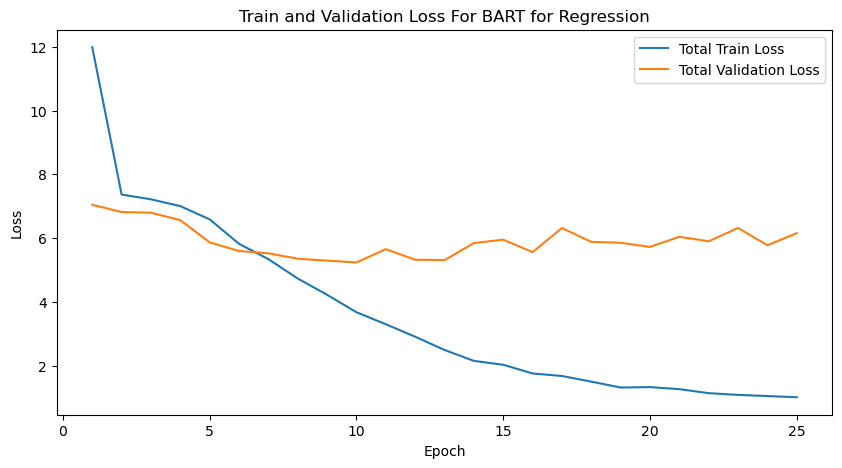

In [47]:
## Plotting the Loss values
df_excel=pd.read_excel("./losses_per_epoch2.xlsx")
plt.figure(figsize = (10, 5))
plt.plot(range(1, 26), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 26), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For BART for Regression')
plt.legend()
plt.savefig("baseline_model_losses.pdf")
plt.show()


In [49]:
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[1803:].reset_index( drop = True)

In [50]:
predictions = []
for sub in tqdm(df.subtitles):
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        predicted_score = regression_output.item()
    predictions.append(predicted_score)

  0%|          | 0/201 [00:00<?, ?it/s]

In [54]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

df_predictions=pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})

true_labels = np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels, predicted_scores)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)

mse:  2.2886737085737194
rmse:  1.5128363125512685
mae:  0.9744045878227671
r2:  0.7052711058621264
evs:  0.7287416666472817


In [59]:
df_100 = pd.read_csv("100_channels_transcripts_v1.csv")

In [60]:
df_100

,video_id,transcript
0,U-C6YtAhkoA,mm hmm. Boy. Oh Macdonald had a farm e young a...
1,Z2jRSAOdwx0,"Tick-tock, tick-tock Tick-tock, tick-tock Tick..."
2,D7P_s0aUmwI,wow. Uh huh. Don't you want to see the Q test ...
3,Ja-4gbnIH1Y,"Yes ,Chuchu! There is a Bunny peeping out of..."
4,QuLEloq1LzM,tv look at the children's heavenly smiles all ...
...,...,...
54298,ZhK9ArGa5bc,[Music] ee ee 5 ah [Music] [ Music] Haenam 2 5...
54299,45sxu_tY_zY,[Music] Some [Music] Uhhhh [Music] Uhhhhh tema...
54300,43_0fvQ0dm0,[MUSIC] Oh oh oh oh oh oh oh oh oh oh oh oh [ ...
54301,C1nui4wyfx0,ugh oh oh oh oh manga very [Music] on Huen 5 5...


In [61]:
df_info = pd.read_csv("yt_views_130_channels.csv")

C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\2608505171.py:1: DtypeWarning: Columns (4,5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_info = pd.read_csv("yt_views_130_channels.csv")


In [62]:
df_info.head(2)

,Unnamed: 0,Title,Video URL,Date Posted,View Count,Likes,Dislikes,API Video Info.,Transcript,date_scraped,Video Info
0,0,Vlad play in Flower shop Surprise for mom,https://www.youtube.com/watch?v=swYHW-cUf6M,2018-11-01T06:00:03Z,34173993,81331.0,NaN,"{'kind': 'youtube#video', 'etag': 'eAFl0n0LZeD...",NaN,2023-06-11,NaN
1,1,Huge Eggs Surprise Toys Challenge with Inflata...,https://www.youtube.com/watch?v=wrvsJRFMMME,2019-09-03T05:00:10Z,185889659,668466.0,NaN,"{'kind': 'youtube#video', 'etag': 'DoABAS-J36t...",NaN,2023-06-11,NaN


In [64]:
#df_info_drop = 

In [67]:
#df_info.drop_duplicates(["video_id"])

In [69]:
df_info['video_id'] = [x.split("=")[-1] for x in df_info['Video URL']]

In [71]:
df_info_drop = df_info.drop_duplicates(["video_id"], ignore_index = True)

In [101]:
from ast import literal_eval
def find_video_topics_in_metadata(video_info):    
    categories = []
    
    try:
        video_info_dict = literal_eval(video_info.replace('https://en.wikipedia.org/wiki/', ''))
        if 'items' in video_info_dict:
            categories = video_info_dict['items'][0]['topicDetails']['topicCategories']

        elif 'topicDetails' in video_info_dict:
            categories = video_info_dict['topicDetails']['topicCategories']
        else:
            categories = []
    except Exception as ex:
        print('error', ex)
    
    return categories

In [87]:
df_info_drop_100 = df_info[df_info['video_id'].isin(df_100['video_id'])].reset_index( drop = True)

In [88]:
df_info_drop_100.head(2)

,Unnamed: 0,Title,Video URL,Date Posted,View Count,Likes,Dislikes,API Video Info.,Transcript,date_scraped,Video Info,video_id
0,0,How To Make Pentagon from Kinetic Sand Lego wi...,https://www.youtube.com/watch?v=pZ--dze6l9k,2022-05-20T10:11:23Z,87554,392.0,NaN,"{'kind': 'youtube#video', 'etag': 'YFM3wqchXyg...",NaN,2023-06-11,NaN,pZ--dze6l9k
1,2,How to make Rainbow Truck WITH Ga Ga Ga Sand &...,https://www.youtube.com/watch?v=xqkCWvVRjck,2022-05-14T14:36:11Z,4034,12.0,NaN,"{'kind': 'youtube#video', 'etag': 'Fmc_WQl8UNT...",NaN,2023-06-11,NaN,xqkCWvVRjck


In [82]:
df_info_drop_100['API Video Info.'][0]

"{'kind': 'youtube#video', 'etag': 'YFM3wqchXygAUNl0HKIMobyjhzQ', 'id': 'pZ--dze6l9k', 'snippet': {'publishedAt': '2022-05-20T10:11:23Z', 'channelId': 'UC_c4psnFX-ZyCUXA_vlXpIQ', 'title': 'How To Make Pentagon from Kinetic Sand Lego with Small Balls ASMR #30', 'description': 'Pentagon from Kinetic Sand Lego with Small Balls ASMR #30', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/pZ--dze6l9k/default.jpg', 'width': 120, 'height': 90}, 'medium': {'url': 'https://i.ytimg.com/vi/pZ--dze6l9k/mqdefault.jpg', 'width': 320, 'height': 180}, 'high': {'url': 'https://i.ytimg.com/vi/pZ--dze6l9k/hqdefault.jpg', 'width': 480, 'height': 360}, 'standard': {'url': 'https://i.ytimg.com/vi/pZ--dze6l9k/sddefault.jpg', 'width': 640, 'height': 480}, 'maxres': {'url': 'https://i.ytimg.com/vi/pZ--dze6l9k/maxresdefault.jpg', 'width': 1280, 'height': 720}}, 'channelTitle': 'Santa Studio', 'categoryId': '20', 'liveBroadcastContent': 'none', 'defaultLanguage': 'en', 'localized': {'title': 'How To Make

In [89]:
df_info_drop_100['Video Info'].isna().value_counts()

Video Info
True     3616549
False      47992
Name: count, dtype: int64

In [96]:
df_info_drop_100 = df_info_drop_100[~df_info_drop_100['Video Info'].isna()].reset_index(drop = True)

In [98]:
df_info_drop_100.head(3)

,Unnamed: 0,Title,Video URL,Date Posted,View Count,Likes,Dislikes,API Video Info.,Transcript,date_scraped,Video Info,video_id
0,0,How to make eggless Microwave Mug Cakes,https://www.youtube.com/watch?v=qyWdUICPdOM,2021-06-09T00:35:05Z,27,5.0,0.0,NaN,NaN,2021-06-11,"{'kind': 'youtube#video', 'etag': 'qj-_sAJ8vMn...",qyWdUICPdOM
1,1,Kung-Fu High Impact - xbox,https://www.youtube.com/watch?v=RNMz6XLmMfg,2021-05-17T22:16:03Z,33,5.0,0.0,NaN,NaN,2021-06-11,"{'kind': 'youtube#video', 'etag': '5hWQs4JUsNL...",RNMz6XLmMfg
2,2,Lego Marvel Avengers All Characters and their ...,https://www.youtube.com/watch?v=sy99tERUUak,2021-05-02T18:39:15Z,103,10.0,0.0,NaN,NaN,2021-06-11,"{'kind': 'youtube#video', 'etag': 'DcsxWmOMhEc...",sy99tERUUak


In [102]:
find_video_topics_in_metadata(df_info_drop_100['Video Info'][0])

['Food', 'Lifestyle_(sociology)']

In [147]:

data_dict = {}

for idx in tqdm(range(len(df_info_drop_100))):
    
    topics = find_video_topics_in_metadata(df_info_drop_100['Video Info'][idx])
    
    for topic in topics:
        try:
            data_dict[topic].append(df_info_drop_100['video_id'][idx])
        except KeyError:
            data_dict[topic] = [df_info_drop_100['video_id'][idx]]

  0%|          | 0/47992 [00:00<?, ?it/s]

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'NoneType' object is not subscriptable
error 'Non

In [148]:
data_dict.keys()

dict_keys(['Food', 'Lifestyle_(sociology)', 'Action-adventure_game', 'Action_game', 'Role-playing_video_game', 'Video_game_culture', 'Hobby', 'Vehicle', 'Racing_video_game', 'Sports_game', 'Entertainment', 'Physical_fitness', 'Film', 'Health', 'Pet', 'Tourism', 'Technology', 'Television_program', 'Humour', 'Performing_arts', 'Pop_music', 'Music', 'Puzzle_video_game', 'Strategy_video_game', 'Knowledge', 'Motorsport', 'Christian_music', 'Music_of_Asia', 'Electronic_music', 'Classical_music', 'Religion', 'Society', 'Business', 'Fashion', 'Country_music', 'Jazz', 'Baseball', 'Hip_hop_music', 'Rock_music', 'Reggae', 'Basketball', 'Independent_music', 'Soul_music', 'Rhythm_and_blues', 'Music_of_Latin_America', 'Association_football', 'Simulation_video_game', 'Casual_game', 'Music_video_game', 'Military', 'Golf', 'Professional_wrestling', 'Sport', 'Ice_hockey', 'Physical_attractiveness', 'American_football'])

In [140]:
#idx = random.randint(0, len(df_info_drop_100))
a =find_video_topics_in_metadata(df_info_drop_100['Video Info'][idx])

error 'NoneType' object is not subscriptable


In [128]:
import random

In [134]:
idx

45750

In [152]:
import itertools
vids_topics = list(itertools.chain(*list(data_dict.values())))

In [158]:
data_dict['Others'] = list(set(df_info_drop_100['video_id']) - set(vids_topics))

In [166]:
df_100_ = df_100[df_100['video_id'].isin(df_info_drop_100['video_id'])].reset_index( drop = True)

In [171]:
df_100_ = {x:y for x, y in zip(df_100_['video_id'], df_100_['transcript'])}

In [173]:

video_id_list = []
topic_list = []
transcript_list = []

for key in list(data_dict.keys()):
    vids = data_dict[key]
    for vid in vids:
        video_id_list.append(vid)
        topic_list.append(key)
        transcript_list.append(df_100_[vid])

In [174]:
df_topic = pd.DataFrame({"video_id":video_id_list, "topic":topic_list, "transcript":transcript_list})

In [178]:
#df_topic['topic'].value_counts()

In [242]:

predicted_rating_list = []
for idx in tqdm(range(len(df_topic))):
    
    try:

        transcript = df_topic['transcript'][idx]

        inputs = tokenizer(transcript, padding='max_length', truncation=True, return_tensors='pt',max_length=1024)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        
        del input_ids, attention_mask
        torch.cuda.empty_cache()
        
        predicted_rating_list.append(regression_output.cpu().detach().item())
        
    except:
        predicted_rating_list.append(None)
        

  0%|          | 0/80379 [00:00<?, ?it/s]

In [243]:
len(df_topic)

80379

In [244]:
#regression_output.cpu().detach().item()

In [245]:
regression_output.item()

3.7176220417022705

In [246]:
#model

In [247]:
#model = model.to(device)

In [248]:
len(predicted_rating_list)

80379

In [249]:
df_topic['predicted_rating'] = predicted_rating_list

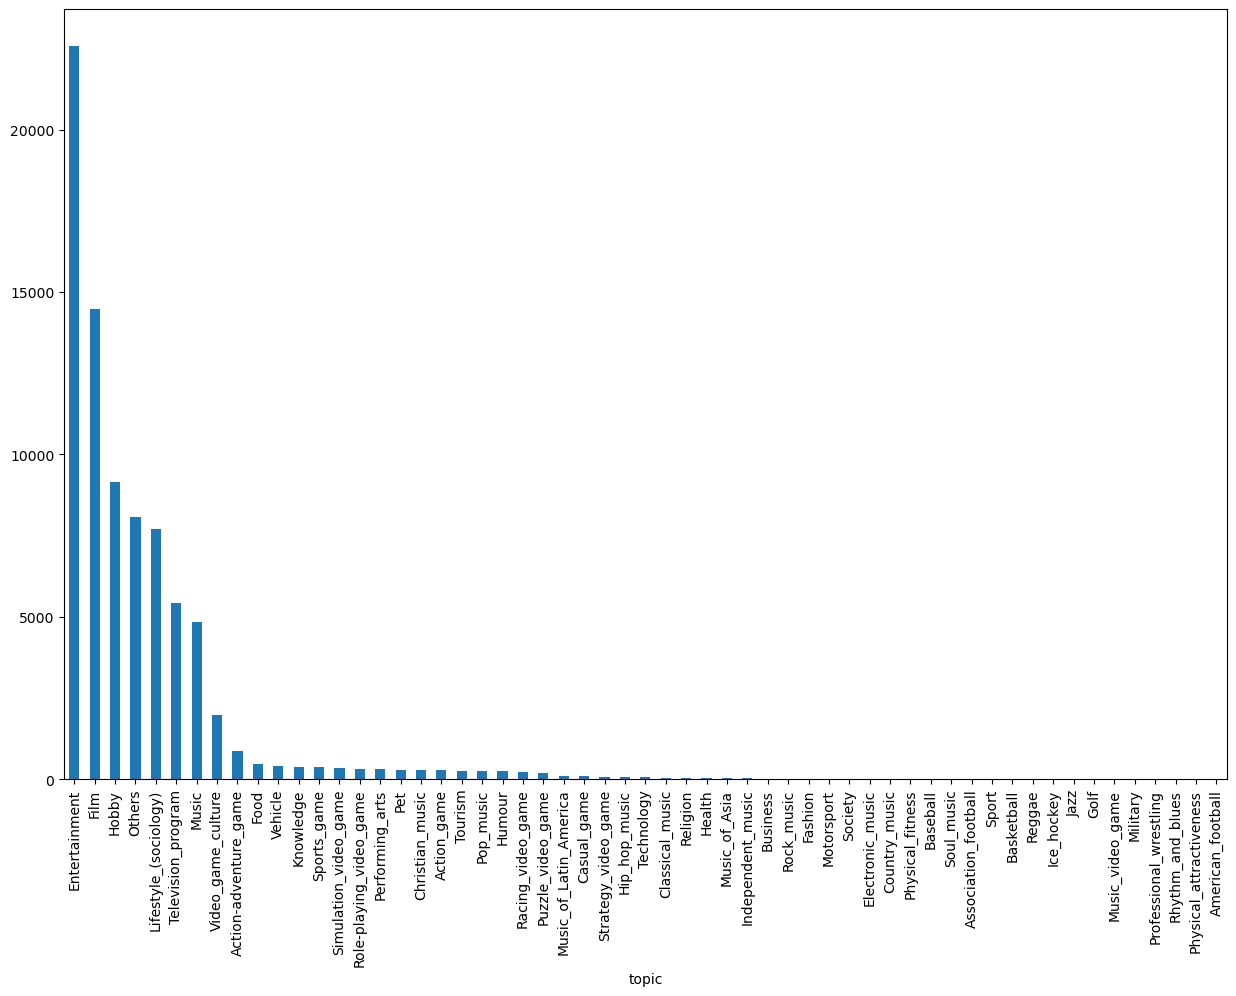

In [218]:
plt.figure(figsize = (15, 10))
df_topic['topic'].value_counts().plot(kind = "bar")
plt.savefig("transcripts_topics_plot.pdf")

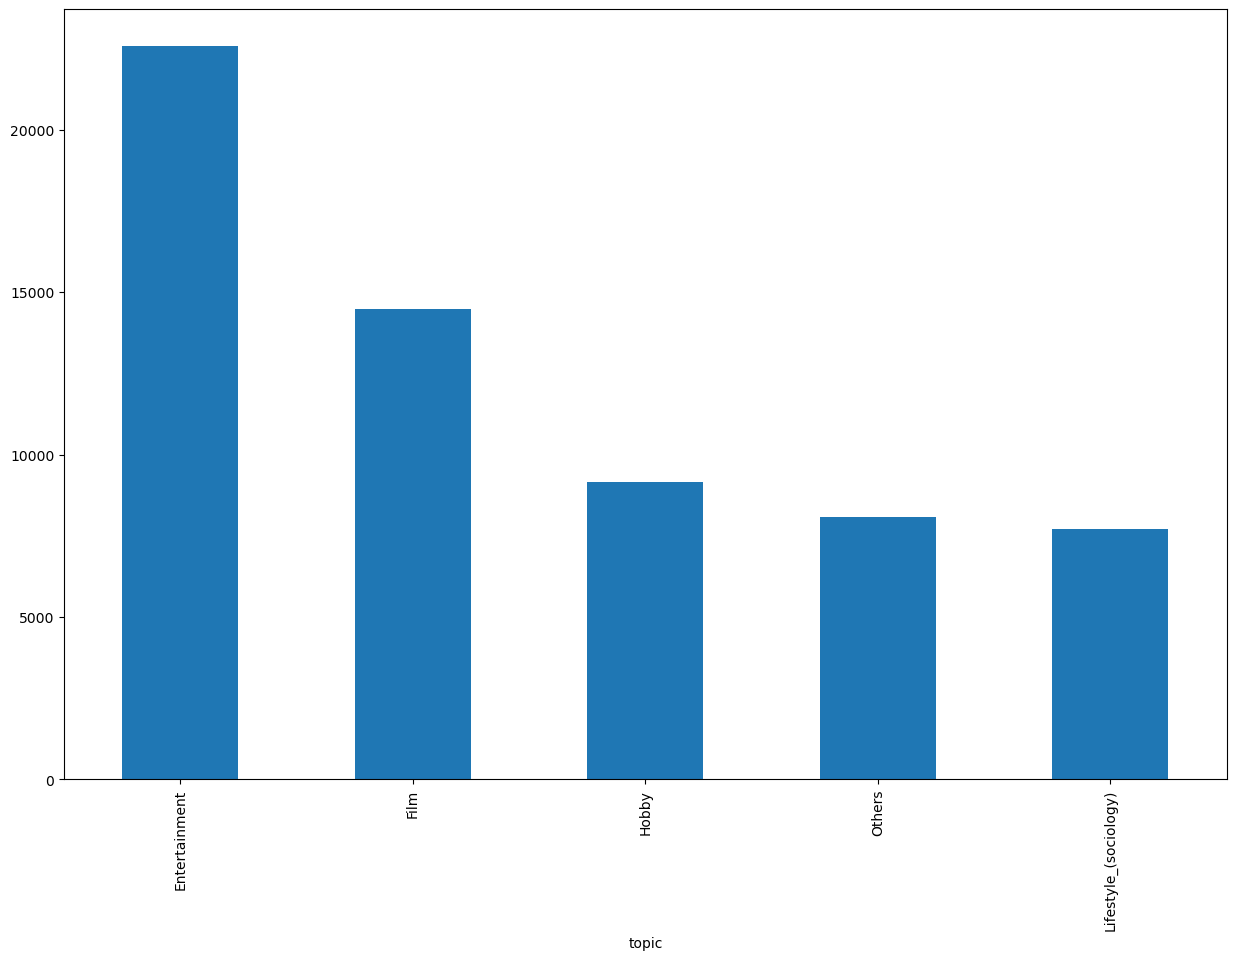

In [223]:
plt.figure(figsize = (15, 10))
df_topic['topic'].value_counts()[:5].plot(kind = "bar")
plt.savefig("transcripts_topics_k-5_plot.pdf")

In [221]:
#df_topic['topic'].value_counts()[:10]

In [270]:
k = 10
topics = list(df_topic['topic'].value_counts()[:k].keys())

In [271]:
topics

['Entertainment',
 'Film',
 'Hobby',
 'Others',
 'Lifestyle_(sociology)',
 'Television_program',
 'Music',
 'Video_game_culture',
 'Action-adventure_game',
 'Food']

In [238]:
df_topic[df_topic['topic'].isin(topics)].groupby("topic")

In [239]:
#df_topic[df_topic['topic'].isin(topics)]

In [250]:
df_topic.to_csv("df_topic1.csv", index = False)

In [251]:
#N1 = len(results_all_without_null)

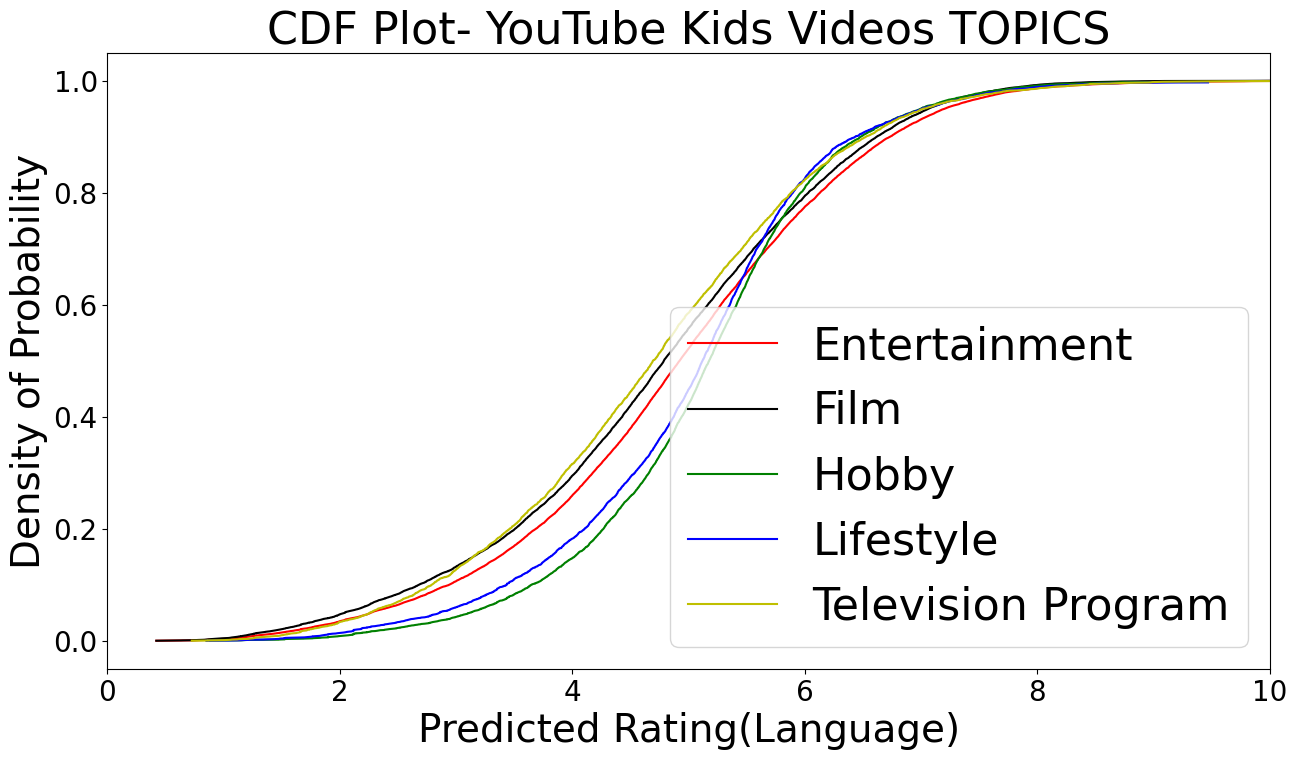

In [381]:


results_entertinement = list(df_topic[df_topic['topic'] == "Entertainment"]['predicted_rating'])
N1 = len(results_entertinement)
x1 = np.sort(results_entertinement)
data1 = np.random.randn(N1)
y1 = (np.arange(N1) / float(N1))

results_film = list(df_topic[df_topic['topic'] == "Film"]['predicted_rating'])
N2 = len(results_film)
x2 = np.sort(results_film)
data2 = np.random.randn(N2)
y2 = (np.arange(N2) / float(N2))


results_hobby = list(df_topic[df_topic['topic'] == "Hobby"]['predicted_rating'])
N3 = len(results_hobby)
x3 = np.sort(results_hobby)
data3 = np.random.randn(N3)
y3 = (np.arange(N3) / float(N3))



results_lifestyle = list(df_topic[df_topic['topic'] == "Lifestyle_(sociology)"]['predicted_rating'])
N4 = len(results_lifestyle)
x4 = np.sort(results_lifestyle)
data4 = np.random.randn(N4)
y4 = (np.arange(N4) / float(N4))

results_television = list(df_topic[df_topic['topic'] == "Television_program"]['predicted_rating'])
N5 = len(results_television)
x5 = np.sort(results_television)
data5 = np.random.randn(N5)
y5 = (np.arange(N5) / float(N5))

plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 10])
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot- YouTube Kids Videos TOPICS',fontsize=32)
plt.plot(x1, y1,color='r',label='Entertainment')
plt.plot(x2, y2,color='k',label='Film')
plt.plot(x3, y3,color='g',label='Hobby')
plt.plot(x4, y4,color='b',label='Lifestyle')
plt.plot(x5, y5,color='y',label='Television Program')
plt.legend(fontsize = '32',loc='lower right')
plt.savefig("topics_ytkids_videos.pdf")
plt.show()

In [350]:
import os
import json
from tqdm import tqdm
tqdm.pandas()

In [280]:
dest_pth = "casestudy_analysis/channels_transcripts/"
transcripts_casestudy = os.listdir(dest_pth)

In [281]:
chan_pth = "casestudy_analysis/channels_list/"
channels_casestudy = os.listdir(chan_pth)

In [295]:
channels_list = []
videos_list = []
for cha in channels_casestudy:
    
    videos = [x.strip().split("=")[-1] for x in open(chan_pth+cha).readlines()]
    videos_list.extend(videos)
    channels_list.extend([cha.split(".")[0]]*len(videos))
    

In [296]:
len(videos_list), len(channels_list)

(34856, 34856)

In [297]:
df_app = pd.DataFrame({"video_id":videos_list, "channel_name":channels_list})

In [298]:
df_app

,video_id,channel_name
0,4edbfXpZka0,UC8eJxPzmvTb12v7LlZUJcLQ
1,m5oF8kVnxiY,UC8eJxPzmvTb12v7LlZUJcLQ
2,J-HnUtud8hM,UC8eJxPzmvTb12v7LlZUJcLQ
3,_6xSIw9uQ-w,UC8eJxPzmvTb12v7LlZUJcLQ
4,vcym9sFt6as,UC8eJxPzmvTb12v7LlZUJcLQ
...,...,...
34851,Q7o2TqW6tJg,UCZQ84csaMpIjQUXK7e2MEmA
34852,FxNHfuk7iss,UCZQ84csaMpIjQUXK7e2MEmA
34853,95_URh04P-w,UCZQ84csaMpIjQUXK7e2MEmA
34854,-iybJhl-PrI,UCZQ84csaMpIjQUXK7e2MEmA


In [304]:
df_app = df_app[df_app['video_id'].isin([x[:11] for x in transcripts_casestudy if ".json" in x])].reset_index( drop = True )

In [306]:
channels = {"appropriate_channels":["UCKAqou7V9FAWXpZd9xtOg3Q", "UCu52CCCjTx-U1BgDO4ZOSpw", "UC8eJxPzmvTb12v7LlZUJcLQ",
                                 "UCK5Q72Uyo73uRPk8PmM2A3w","UCudZ1fVvCSPMoVcqa7kxgGw", "UCZQ84csaMpIjQUXK7e2MEmA",
                                 "UCLy6-72NzYpFztbJ7jNEMkg", "UCx790OVgpTC1UVBQIqu3gnQ"],
            "inappropriate_channels":["UCjJYD85vaiBowhJNqY_pZOw","UCGg7sieCe-yCcl67QNlVsrQ", "UCF-sao1ypdpTmq1CFhJ4Iqg",
                                 "UCxOGHW-aqciBe5Wjq8ltzOg", "UCWwWOFsW68TqXE-HZLC3WIA", "UCOo_v3eVbfET7_zi2KLOP9g", 
                                 "UCXOnbXXYdR4yJh4ONpynHtw", "UChLtXXpo4Ge1ReTEboVvTDg", "UCNvVDGaj-_KVMLKXK2u2fjw"]}

In [318]:

cha_dict = {}
for cha in channels:
    
    vids = channels[cha]
    
    for vid in vids:
        cha_dict[vid] = cha
    

In [321]:
df_app['category'] = df_app['channel_name'].map(cha_dict)

In [344]:

def get_transcript(vid):
    
    return " ".join([x['text'] for x in json.loads(open(dest_pth+vid+".json").read())])


In [361]:
df_app['transcript'] = df_app['video_id'].apply(get_transcript)

In [363]:


## Cleaning the transcripts 

s_words = ["[Music]", "[Applause]", 'music', 'Music',"i'll", "i'm", "[Laughter]","[THEME MUSIC]",  "[SINGING]",
            "music", "[music]", "[applause]", "[Laughter]"]

def clean_transcript(transcript):
    
    transcription = []
    
    #print(transcript)
    transcript = transcript.lower().split()
    
    for tra in transcript:
        if tra not in s_words:
            transcription.append(tra)
            
    return " ".join(transcription)
    
df_app['transcript'] = df_app['transcript'].progress_apply(clean_transcript)

100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 1525.59it/s]


In [366]:

predicted_app_rating_list = []
for idx in tqdm(range(len(df_app))):
    
    try:

        transcript = df_app['transcript'][idx]

        inputs = tokenizer(transcript, padding='max_length', truncation=True, return_tensors='pt',max_length=1024)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        
        del input_ids, attention_mask
        torch.cuda.empty_cache()
        
        predicted_app_rating_list.append(regression_output.cpu().detach().item())
        
    except:
        predicted_app_rating_list.append(None)
        

100%|████████████████████████████████████████████████████████████████████████████████| 309/309 [00:38<00:00,  8.02it/s]


In [367]:
len(predicted_app_rating_list)

309

In [369]:
#df_app

In [370]:
df_app['predicted_rating'] = predicted_app_rating_list

In [375]:
df_app['category'].value_counts()

category
inappropriate_channels    155
appropriate_channels      154
Name: count, dtype: int64

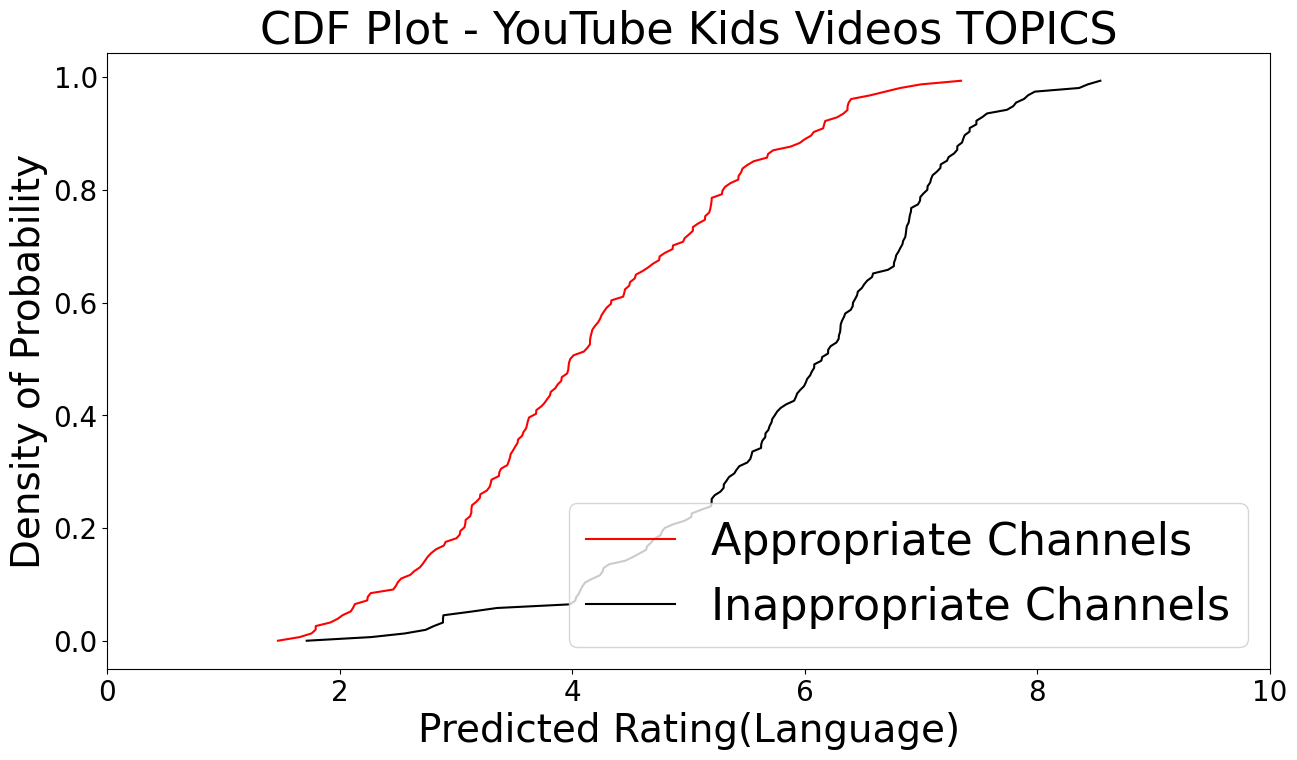

In [385]:


results_appropriate = list(df_app[df_app['category'] == "appropriate_channels"]['predicted_rating'])
N1 = len(results_appropriate)
x1 = np.sort(results_appropriate)
data1 = np.random.randn(N1)
y1 = (np.arange(N1) / float(N1))

results_inappropriate = list(df_app[df_app['category'] == "inappropriate_channels"]['predicted_rating'])
N2 = len(results_inappropriate)
x2 = np.sort(results_inappropriate)
data2 = np.random.randn(N2)
y2 = (np.arange(N2) / float(N2))


plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 10])
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot - YouTube Kids Videos TOPICS',fontsize=32)
plt.plot(x1, y1,color='r',label='Appropriate Channels')
plt.plot(x2, y2,color='k',label='Inappropriate Channels')
plt.legend(fontsize = '32',loc='lower right')
plt.savefig("sambda_dataset.pdf")
plt.show()

In [388]:
foul_words = [x.lower().strip() for x in open("./final_lexicon_aaai.txt").readlines()]

In [392]:
df_app['transcript'][0]

"[laughter] hello happy friends are you ready to learn sarah and in happy learning we enjoy puzzles and riddles so much that we've come up with the idea of solving a puzzle with toothpicks it's called the fish's puzzle the first thing we're going to do is make a fish out of eight toothpicks we get four toothpicks to make the body then we add two for the tail and two for the fins well done hello little fishy now by moving only three toothpicks we need to make our fish swim in the opposite direction take all the time you need pause the video and don't worry if you can't solve it because later we're going to solve it together pause the video have you figured it out yet sure you have so let's take a look hello little fishy we already know that we we need to move three toothpicks to make our fish move in the opposite direction so if we move this one this one and this toothpick and then we place them here here and here that's it woohoo we've done it our fish is swimming in the opposite direc

In [394]:

def get_foul_words(transcript):
    
    foul_word_list = []
    transcript_words = transcript.lower().split()
    
    for word in transcript_words:
        if word in foul_words:
            foul_word_list.append(word)
            
    return foul_word_list
    

In [395]:
df_app['inappropriate_words'] = df_app['transcript'].progress_apply(get_foul_words)

100%|████████████████████████████████████████████████████████████████████████████████| 309/309 [00:11<00:00, 27.52it/s]


In [398]:
df_app['number_of_foul_words'] = [len(x) for x in df_app['inappropriate_words']]

In [406]:
df_app_in = df_app[(df_app['number_of_foul_words'] > 15) & (df_app['category'] == "inappropriate_channels")].reset_index(drop = True)

In [410]:
df_app_in.head(3)

,video_id,channel_name,category,transcript,predicted_rating,inappropriate_words,number_of_foul_words
0,mce7w1AAOsM,UCGg7sieCe-yCcl67QNlVsrQ,inappropriate_channels,an act of god or an act of clw oh you know thi...,5.907250,"[god, damn, bum, crap, butt, butt, butt, butt,...",22
1,X7dsCaOAz0Q,UCjJYD85vaiBowhJNqY_pZOw,inappropriate_channels,oh fer that thing stinks that's gross this is ...,7.885932,"[gross, gross, crime, dead, die, knife, fool, ...",20
2,dBmg-igCDMU,UCjJYD85vaiBowhJNqY_pZOw,inappropriate_channels,ladies and gentlemen boys and girls kids of al...,7.283075,"[dead, fat, asses, boom, liquor, harder, harde...",17


In [409]:
df_kids = pd.read_csv("kidsInMindSubtitles2004.csv")
df_kids.shape

(2004, 15)

In [412]:
idx = 0

In [421]:
query = "Given the subtitle rating of a movie = "+str(round(df_app_in['predicted_rating'][idx], 1))+" \
; and a list of inappropriate words : "+ str(df_app_in['inappropriate_words'][idx]) + " Generate \
language summary like kids in mind website? Please consider the below two example language summaries of \
movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
print(query)

Given the subtitle rating of a movie = 5.9 ; and a list of inappropriate words : ['god', 'damn', 'bum', 'crap', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'gay', 'damn', 'god', 'god', 'god', 'god', 'damn'] Generate language summary like kids in mind website? Please consider the below two example language summaries of movies:  
 1.At least 1 F-word, 4 scatological terms (1 mild), 4 anatomical terms, 3 mild obscenities, name-calling (freak, psycho, foolish, boring, stubborn, little man), 4 religious exclamations.
 2. About 67 F-words and its derivatives, 2 obscene hand gestures, 12 sexual references, 38 scatological terms, 38 anatomical terms, 39 mild obscenities, name-calling (crazy, moron, idiots, dumb, sluts, stupid, psycho, punk, Negro, drunks, school boy, boring, pussy whipped, mini-mite, corny, Little Miss Overachiever, homosexual), stereotypical references to corporate officials, bosses, single men, single women, Jews, Koreans, the Chin

In [425]:


import os
import openai

openai.organization = ""
openai.api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXX"



response_id_done = {}
import re
import json

import openai  # for OpenAI API calls
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff


@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.Completion.create(**kwargs)


In [429]:

from openai import OpenAI
os.environ["OPENAI_API_KEY"] = "XXXXXXXXXXXXXXXXXXXXXXXXXX"


client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    # api_key="My API Key",
)
from docx import Document

def transcribe_audio(audio_file_path):
    with open(audio_file_path, 'rb') as audio_file:
        transcription = client.audio.transcriptions.create("whisper-1", audio_file)
    return transcription['text']

In [430]:
model_name = 'gpt-4'

In [431]:
response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )

In [442]:
response.choices[0].message.content

'About 5 religious exclamations (god), 3 mild obscenities (damn), 1 anatomical term (butt) used 10 times, 1 term that could be considered a mild sexual reference or derogatory term (gay).'

In [444]:
query

"Given the subtitle rating of a movie = 5.9 ; and a list of inappropriate words : ['god', 'damn', 'bum', 'crap', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'butt', 'gay', 'damn', 'god', 'god', 'god', 'god', 'damn'] Generate language summary like kids in mind website? Please consider the below two example language summaries of movies:  \n 1.At least 1 F-word, 4 scatological terms (1 mild), 4 anatomical terms, 3 mild obscenities, name-calling (freak, psycho, foolish, boring, stubborn, little man), 4 religious exclamations.\n 2. About 67 F-words and its derivatives, 2 obscene hand gestures, 12 sexual references, 38 scatological terms, 38 anatomical terms, 39 mild obscenities, name-calling (crazy, moron, idiots, dumb, sluts, stupid, psycho, punk, Negro, drunks, school boy, boring, pussy whipped, mini-mite, corny, Little Miss Overachiever, homosexual), stereotypical references to corporate officials, bosses, single men, single women, Jews, Koreans, the C

In [448]:
df_app_in.head(2)

,video_id,channel_name,category,transcript,predicted_rating,inappropriate_words,number_of_foul_words
0,mce7w1AAOsM,UCGg7sieCe-yCcl67QNlVsrQ,inappropriate_channels,an act of god or an act of clw oh you know thi...,5.907250,"[god, damn, bum, crap, butt, butt, butt, butt,...",22
1,X7dsCaOAz0Q,UCjJYD85vaiBowhJNqY_pZOw,inappropriate_channels,oh fer that thing stinks that's gross this is ...,7.885932,"[gross, gross, crime, dead, die, knife, fool, ...",20


In [449]:
df_app_in['gpt_4_response'] =  None

In [452]:

for idx in range(len(df_app_in)):
    
    query = "Given the subtitle rating of a movie = "+str(round(df_app_in['predicted_rating'][idx], 1))+" \
    ; and a list of inappropriate words : "+ str(df_app_in['inappropriate_words'][idx]) + " Generate \
    language summary like kids in mind website? Please consider the below two example language summaries of \
    movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
    
    response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )
    
    
    
    with open("gpt_4_reponse_samba_dataset_samples.json", "a") as file:
        file.write(json.dumps(str(idx)+":"+str(response)+"\n"))
        
    df_app_in['gpt_4_response'][idx] = response
    
    if idx == 7:
        break

C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\3627764205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in['gpt_4_response'][idx] = response
C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\3627764205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in['gpt_4_response'][idx] = response
C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\3627764205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [461]:
df_app_in_ = df_app_in[:8]

In [462]:
len(df_app_in_)

8

In [463]:
df_app_in_['gpt_4_response'][0]

ChatCompletion(id='chatcmpl-9ly2DVptjFNg6eqKTRfjhcKuFQpnz', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The movie contains 5 instances of religious exclamations ('god'), 3 instances of mild obscenities ('damn'), 1 scatological term ('crap'), 1 anatomical term ('bum'), and 10 instances of mild anatomical terms ('butt'). There is also 1 instance of a term that could be interpreted as a derogatory reference to sexual orientation ('gay').", role='assistant', function_call=None, tool_calls=None))], created=1721219217, model='gpt-4-0613', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=78, prompt_tokens=358, total_tokens=436))

In [465]:
df_app_in_['gpt_4_response'] = [res.choices[0].message.content for res in df_app_in_['gpt_4_response']]

C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\1214113144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in_['gpt_4_response'] = [res.choices[0].message.content for res in df_app_in_['gpt_4_response']]


In [468]:
df_app_in_['gpt_4_response']

0    The movie contains 5 instances of religious ex...
1    The movie contains 5 instances of the word 'gr...
2    About 3 scatological terms ('ass', 'asses'), 5...
3    5 uses of 'damn', 6 uses of 'god', 3 uses of '...
4    3 religious exclamations (god), 6 mild obsceni...
5    About 7 uses of 'god', 5 uses of 'damn', 3 use...
6    About 4 religious exclamations (god), 3 mild o...
7    About 11 religious exclamations (e.g. 'god'), ...
Name: gpt_4_response, dtype: object

In [ ]:
df_app_in = df_app[(df_app['number_of_foul_words'] > 15) & (df_app['category'] == "inappropriate_channels")].reset_index(drop = True)

In [476]:
df_app_in1 = df_app[(df_app['predicted_rating'] < 4) & (df_app['category'] == "inappropriate_channels")].reset_index(drop = True)

In [485]:
df_app_in1['gpt_4_response'] =  None

In [486]:

for idx in range(len(df_app_in1)):
    
    query = "Given the subtitle rating of a movie = "+str(round(df_app_in1['predicted_rating'][idx], 1))+" \
    ; and a list of inappropriate words : "+ str(df_app_in1['inappropriate_words'][idx]) + " Generate \
    language summary like kids in mind website? Please consider the below two example language summaries of \
    movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
    
    response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )
    
    
    
    with open("gpt_4_reponse_samba_dataset_samples.json", "a") as file:
        file.write(json.dumps(str(idx)+":"+str(response)+"\n"))
        
    df_app_in1['gpt_4_response'][idx] = response

C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\4144197795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in1['gpt_4_response'][idx] = response
C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\4144197795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in1['gpt_4_response'][idx] = response
C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\4144197795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [487]:
df_app_in1['gpt_4_response'] = [res.choices[0].message.content for res in df_app_in1['gpt_4_response']]

In [488]:
df_app_in1['gpt_4_response']

0     The movie contains a moderate amount of inappr...
1     The movie contains a few instances of inapprop...
2     The movie contains a few instances of inapprop...
3     The movie has a subtitle rating of 3.1, indica...
4     The movie contains a moderate amount of inappr...
5     The movie has a subtitle rating of 1.7, indica...
6     The movie contains a few instances of strong l...
7     The movie contains 5 instances of the word 'ki...
8     The movie has a subtitle rating of 2.9, indica...
9     The movie contains a moderate amount of inappr...
10    The movie contains a few instances of inapprop...
Name: gpt_4_response, dtype: object

In [489]:
df_inappropriate = pd.concat([df_app_in_, df_app_in1], ignore_index = True)

In [496]:
df_app_in2 = df_app[df_app['predicted_rating'] == df_app['predicted_rating'].max()].reset_index(drop = True)

In [494]:
df_inappropriate['predicted_rating'].max()

7.885932445526123

In [497]:
df_app_in2['gpt_4_response'] = None

In [498]:

for idx in range(len(df_app_in2)):
    
    query = "Given the subtitle rating of a movie = "+str(round(df_app_in2['predicted_rating'][idx], 1))+" \
    ; and a list of inappropriate words : "+ str(df_app_in2['inappropriate_words'][idx]) + " Generate \
    language summary like kids in mind website? Please consider the below two example language summaries of \
    movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
    
    response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )
    
    
    
    with open("gpt_4_reponse_samba_dataset_samples.json", "a") as file:
        file.write(json.dumps(str(idx)+":"+str(response)+"\n"))
        
    df_app_in2['gpt_4_response'][idx] = response

C:\Users\31409\AppData\Local\Temp\25\ipykernel_45828\1279185002.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_in2['gpt_4_response'][idx] = response


In [569]:
df_app_in2['gpt_4_response'] = [res.choices[0].message.content for res in df_app_in2['gpt_4_response']]

In [570]:
df_inappropriate = pd.concat([df_app_in_, df_app_in1, df_app_in2], ignore_index = True)

In [500]:
df_inappropriate['predicted_rating'].max()

8.54141902923584

In [506]:
from random import sample

In [535]:
list1 = sample(list(df_app['predicted_rating']), 10)

In [536]:
list1

[5.022346496582031,
 5.790841102600098,
 4.6781792640686035,
 5.002808570861816,
 4.651916980743408,
 8.54141902923584,
 6.455610275268555,
 3.6170549392700195,
 5.6833062171936035,
 1.980908989906311]

In [542]:
df_app[df_app['category'] == "appropriate_channels"]['predicted_rating'].min()

1.467124581336975

In [543]:
df_app[df_app['category'] == "appropriate_channels"]['predicted_rating'].max()

7.343403339385986

In [558]:
list1 = sample(list(df_app[df_app['category'] == "appropriate_channels"]['predicted_rating']), 10)

In [582]:
df_appropriate = df_app[~df_app['predicted_rating'].isin(list1)][:10].reset_index(drop = True)

In [583]:
df_appropriate['gpt_4_response'] = None

In [584]:
import warnings
warnings.filterwarnings("ignore")

In [585]:

for idx in range(len(df_appropriate)):
    
    query = "Given the subtitle rating of a movie = "+str(round(df_appropriate['predicted_rating'][idx], 1))+" \
    ; and a list of inappropriate words : "+ str(df_appropriate['inappropriate_words'][idx]) + " Generate \
    language summary like kids in mind website? Please consider the below two example language summaries of \
    movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
    
    response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )
    
    
    
    with open("gpt_4_reponse_samba_dataset_samples.json", "a") as file:
        file.write(json.dumps(str(idx)+":"+str(response)+"\n"))
        
    df_appropriate['gpt_4_response'][idx] = response

In [586]:
df_appropriate['gpt_4_response'] = [res.choices[0].message.content for res in df_appropriate['gpt_4_response']]

In [587]:
df_appropriate['gpt_4_response']

0    The movie has a subtitle rating of 3.4, indica...
1    The movie contains about 5 uses of the word 'k...
2    The movie has a subtitle rating of 4.9, indica...
3    The movie contains moderate language, with a s...
4    The movie has a subtitle rating of 4.8, indica...
5    The movie contains several inappropriate words...
6    The movie has a subtitle rating of 6.3, indica...
7    The movie has a subtitle rating of 3.8, indica...
8    The movie has a subtitle rating of 5.5, indica...
9    The movie has a subtitle rating of 3.1, indica...
Name: gpt_4_response, dtype: object

In [590]:
df_appropriate[['inappropriate_words', 'predicted_rating']]

,inappropriate_words,predicted_rating
0,[],3.367691
1,"[crash, bigger, kill, dead, killed, drunk, sho...",4.861220
2,[],4.865567
3,[cancer],5.451485
4,[],4.797292
5,"[period, period, death, god, god, god, death, ...",4.746070
6,[],6.276093
7,"[kill, dead, killed, destroy, die, ugly]",3.761128
8,[],5.462951
9,"[ass, beast, latin]",3.119793


In [597]:
df_appropriate.iloc[9]

video_id                                                      NqPN1RAyYDk
channel_name                                     UC8eJxPzmvTb12v7LlZUJcLQ
category                                             appropriate_channels
transcript              hello happy friends are you ready to learn sar...
predicted_rating                                                 3.119793
inappropriate_words                                   [ass, beast, latin]
number_of_foul_words                                                    3
gpt_4_response          The movie has a subtitle rating of 3.1, indica...
Name: 9, dtype: object

In [598]:
df_appropriate.iloc[9]['gpt_4_response']

"The movie has a subtitle rating of 3.1, indicating a moderate use of inappropriate language. The language includes the use of the words 'ass', 'beast', and 'latin', which may be considered offensive or inappropriate. There are no explicit F-words, scatological terms, or anatomical terms. However, there may be mild obscenities and name-calling. There are no religious obscenities or exclamations. Parents are advised to consider the language content before allowing their children to watch this movie."

In [573]:
df_table = pd.concat([df_appropriate, df_inappropriate], ignore_index = True)

In [574]:
df_table.shape

(30, 8)

In [575]:
df_inappropriate.shape

(20, 8)

In [577]:
df_table['category'].value_counts()

category
inappropriate_channels    20
appropriate_channels      10
Name: count, dtype: int64

In [578]:
df_table.to_csv("table_dataset_samba_dataset.csv", index = False)

In [579]:
df_appropriate

,video_id,channel_name,category,transcript,predicted_rating,inappropriate_words,number_of_foul_words,gpt_4_response
0,f9ONXd_-anM,UC8eJxPzmvTb12v7LlZUJcLQ,appropriate_channels,hello friends welcome to a new happy learning ...,4.965923,[],0,The movie has a subtitle rating of 5.0 and con...
1,g1iRo0osr58,UCKAqou7V9FAWXpZd9xtOg3Q,appropriate_channels,little baby bum let's try to eat eat eat rasbe...,5.726899,[bum],1,The movie contains a moderate amount of inappr...
2,LZ4hxG1q7JI,UCKAqou7V9FAWXpZd9xtOg3Q,appropriate_channels,little baby bump halloween is dress up dress u...,3.609533,"[damn, bigger]",2,The movie contains a few instances of inapprop...
3,PGw200vWs28,UCKAqou7V9FAWXpZd9xtOg3Q,appropriate_channels,(soft bells chiming) ♫ i hear thunder ♫ i hear...,4.272658,"[fat, ho, ho, ho, ho, ho, ho, ho, ho, ho, yank...",35,"About 9 uses of the term 'ho', 9 uses of the t..."
4,bbObKKW9yFM,UCu52CCCjTx-U1BgDO4ZOSpw,appropriate_channels,it is springtime grandpa pig has made a chocol...,1.790872,"[pot, pot, harder, hole, banging]",5,"The movie has a subtitle rating of 1.8, indica..."
5,H85nFEr7PXE,UCu52CCCjTx-U1BgDO4ZOSpw,appropriate_channels,caves today peppa and her family are visiting ...,2.639490,"[doom, doom, doom, doom, doom, doom, doom, doo...",21,"8 uses of the word 'doom', 1 use of 'harder', ..."
6,N-NyYVvIGgQ,UCZQ84csaMpIjQUXK7e2MEmA,appropriate_channels,go start finish w yeah yoo hold start finish g...,5.955226,[ho],1,The movie contains a moderate amount of inappr...
7,ii0LCYVK6fk,UCZQ84csaMpIjQUXK7e2MEmA,appropriate_channels,sometimes start foreign foreign foreign start ...,5.139703,"[god, god, kill]",3,The movie contains 2 religious exclamations us...
8,pOGsje3ZkDQ,UCZQ84csaMpIjQUXK7e2MEmA,appropriate_channels,wait three two one yeah yeah yeah yeah yeah ye...,7.343403,[damn],1,The movie contains the use of the inappropriat...
9,S2XUKViCdd4,UCZQ84csaMpIjQUXK7e2MEmA,appropriate_channels,oh ow ah oh yes oh yes talk to you oh yes uh w...,5.036446,[],0,"The movie has a subtitle rating of 5.0, indica..."


In [601]:
from datasets import load_dataset

ds = load_dataset("ajibawa-2023/Children-Stories-Collection")

Generating train split:   0%|          | 0/896668 [00:00<?, ? examples/s]

In [618]:
df_stories = pd.DataFrame({"text":ds['train']['text']})

In [622]:
df_stories = df_stories.sample(1000, ignore_index = True)

In [624]:

predicted_app_rating_list = []
for idx in tqdm(range(len(df_stories))):
    
    try:

        transcript = df_stories['text'][idx]

        inputs = tokenizer(transcript, padding='max_length', truncation=True, return_tensors='pt',max_length=1024)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        
        del input_ids, attention_mask
        torch.cuda.empty_cache()
        
        predicted_app_rating_list.append(regression_output.cpu().detach().item())
        
    except:
        predicted_app_rating_list.append(None)
        

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:00<00:00,  8.28it/s]


In [625]:
len(predicted_app_rating_list)

1000

In [626]:
df_stories['predicted_rating'] = predicted_app_rating_list

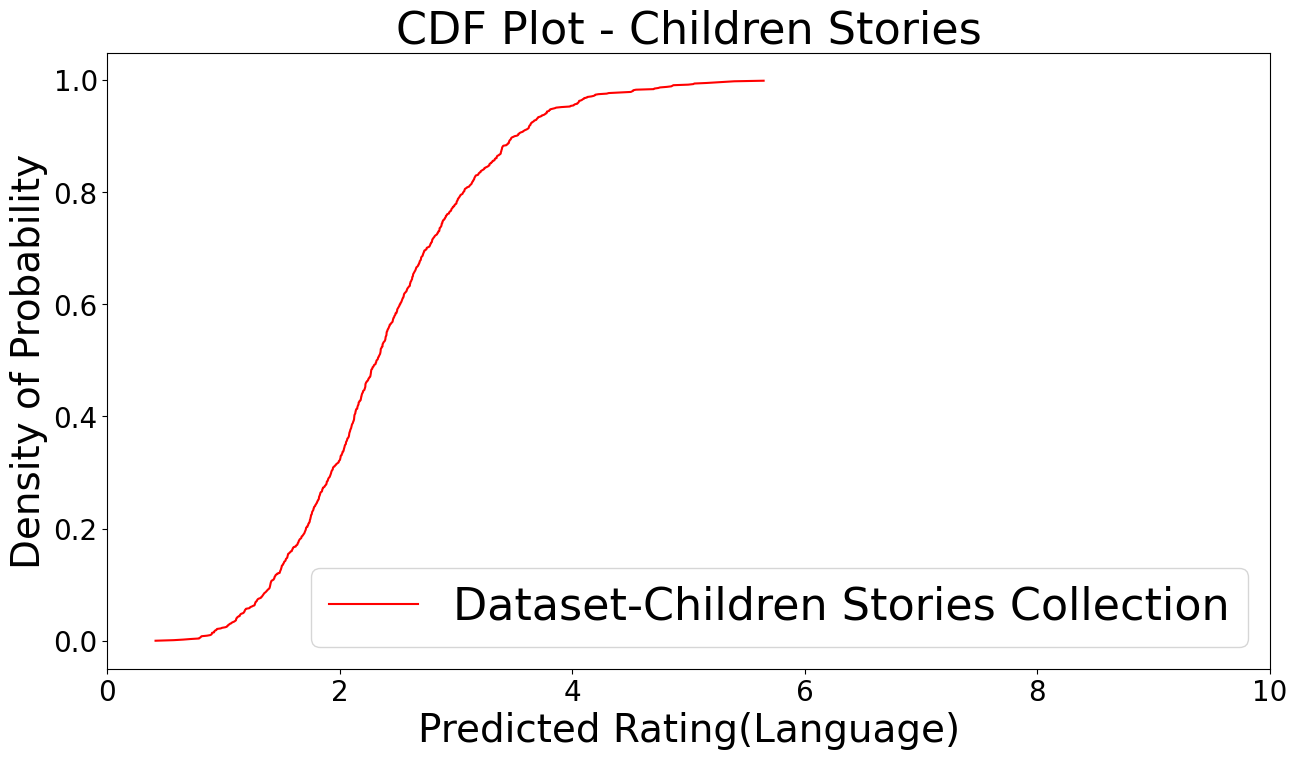

In [628]:


results_children_stories = list(df_stories['predicted_rating'])
N1 = len(results_children_stories)
x1 = np.sort(results_children_stories)
data1 = np.random.randn(N1)
y1 = (np.arange(N1) / float(N1))



plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 10])
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot - Children Stories',fontsize=32)
plt.plot(x1, y1,color='r',label='Dataset-Children Stories Collection')
#plt.plot(x2, y2,color='k',label='Inappropriate Channels')
plt.legend(fontsize = '32',loc='lower right')
plt.savefig("childre_stories_collection_dataset.pdf")
plt.show()

In [629]:
df_stories

,text,predicted_rating
0,"In a small town named Knowville, lived three ...",2.857505
1,"In a lush green garden, there lived two curio...",1.635989
2,Once a group of curious little airplanes name...,1.748043
3,Billy and Suzy loved exploring their backyard...,2.467765
4,"In a bright and sunny day, little Timmy looke...",1.362642
...,...,...
995,"High above the clouds, in a tiny airplane, fl...",2.123696
996,"In a bustling town called Lexington, two curi...",1.772273
997,Once upon a time in a land filled with colorf...,1.290126
998,"It was a sunny day and Hannah, Olivia, and An...",4.704881


In [632]:
childrens_df = pd.DataFrame({"text":ds['train']['text'], "prompt":ds['train']['text']})

In [723]:
print(childrens_df['prompt'][0])

 Once upon a time in the land of Policymia, there lived two leaders named Majora and Minoro. Their job was to make sure all the citizens had beautiful parks, clean water, and top-notch schools. But there were so many things to fix! How would they ever decide where to start?

Majora, being the wise leader she was, knew just what to do. She invited her fellow policymakers for a big meeting at the Roundtable of Representatives. There, they discussed the most important problems Policymia faced. This was called identifying "key policy areas." It meant figuring out which topics needed attention first.

Next came assessing support – finding out if everyone agreed on the solutions. Some people thought building more playgrounds was the way to go, while others wanted better libraries. To understand everyone's thoughts, Majora used something called 'polling.' Just like taking a vote, polling helped her see what ideas were popular among her friends (the majority) and also those across the aisle (p

In [724]:
print(childrens_df['text'][0])

 Once upon a time in the land of Policymia, there lived two leaders named Majora and Minoro. Their job was to make sure all the citizens had beautiful parks, clean water, and top-notch schools. But there were so many things to fix! How would they ever decide where to start?

Majora, being the wise leader she was, knew just what to do. She invited her fellow policymakers for a big meeting at the Roundtable of Representatives. There, they discussed the most important problems Policymia faced. This was called identifying "key policy areas." It meant figuring out which topics needed attention first.

Next came assessing support – finding out if everyone agreed on the solutions. Some people thought building more playgrounds was the way to go, while others wanted better libraries. To understand everyone's thoughts, Majora used something called 'polling.' Just like taking a vote, polling helped her see what ideas were popular among her friends (the majority) and also those across the aisle (p

In [645]:
df_stories[(df_stories['predicted_rating'] < 3) & (df_stories['predicted_rating'] > 4)]

,text,predicted_rating


In [657]:
#df_stories[(df_stories['predicted_rating'] > 4)]

In [653]:
#df_stories[(df_stories['predicted_rating'] < 3)]

In [658]:
#[997, 994, 995, 0, 1, 2, 3, 629, 575, 770, 272]

In [662]:
df_stories.reset_index(inplace = True)

In [684]:
df_stories['inappropriate_words'] = df_stories['text'].apply(get_foul_words)

In [687]:
df_stories['number_of_inappropriate_words'] = [len(x) for x in df_stories['inappropriate_words']]

In [712]:
df_stories[df_stories['number_of_inappropriate_words'] == 4]

,index,text,predicted_rating,inappropriate_words,number_of_inappropriate_words
519,519,"Once upon a time, in a land far away called M...",3.209892,"[death, killing, fairy, death]",4
685,685,Little Beaver was so excited! He had finally ...,1.334082,"[beaver, beaver, beaver, beaver]",4


In [692]:
df_stories['number_of_inappropriate_words'].max()

6

In [713]:
df_stories[df_stories['index'].isin([519, 37, 304, 418, 464, 625, 633, 766, 778, 887])]

,index,text,predicted_rating,inappropriate_words,number_of_inappropriate_words
37,37,Once upon a time in a small village in South ...,2.657256,"[corruption, welfare, bigger]",3
304,304,Little Sammy and his friends loved Halloween!...,1.174594,"[devil, hell, devil]",3
418,418,"Once upon a time, Sally the Seahorse and Timm...",1.811672,"[tang, virgin, virgin]",3
464,464,"Once upon a time, in a land filled with all k...",2.161331,"[kinky, kinky, harder]",3
519,519,"Once upon a time, in a land far away called M...",3.209892,"[death, killing, fairy, death]",4
625,625,Randy was a brilliant engineer who worked alo...,2.911618,"[randy, randy, randy]",3
633,633,"Once upon a time, in a small town called Harm...",4.010469,"[rabbi, conservative, rabbi]",3
766,766,"Every morning in the town of Fruitville, the ...",1.925813,"[fat, harder, burn]",3
778,778,"Once upon a time, in the peaceful town of Har...",2.124889,"[crimes, crimes, criminal]",3
887,887,"Once upon a time, in a small town called Harm...",3.285748,"[church, god, church]",3


In [699]:
#[997, 994, 995, 0, 1, 2, 3, 629, 575, 770, 272, 8, 9, 15]

In [715]:
df_stories_tbl = df_stories[df_stories['index'].isin([519, 37, 304, 418, 464, 625, 633, 766, 778, 887])]
df_stories_tbl.reset_index(drop = True, inplace = True)
df_stories_tbl.drop(['index'], axis = 1, inplace = True)

In [716]:
df_stories_tbl['inappropriate_words'] = df_stories_tbl['text'].apply(get_foul_words)

In [717]:
df_stories_tbl['gpt_4_response'] = None

In [718]:

for idx in tqdm(range(len(df_stories_tbl))):
    
    query = "Given the subtitle rating of a movie = "+str(round(df_stories_tbl['predicted_rating'][idx], 1))+" \
    ; and a list of inappropriate words : "+ str(df_stories_tbl['inappropriate_words'][idx]) + " Generate \
    language summary like kids in mind website? Please consider the below two example language summaries of \
    movies:  \n 1." + df_kids['Language_Description'][0] + "\n 2."+df_kids['Language_Description'][1]
    
    response = client.chat.completions.create( model="gpt-4",
                                          temperature=0,
                                          messages=[{
                                              "role": "system",
                                              "content": query, 
                                          }
                                          ]
                                         )
    
    
    
    with open("gpt_4_reponse_children_stories_dataset_samples.json", "a") as file:
        file.write(json.dumps(str(idx)+":"+str(response)+"\n"))
        
    df_stories_tbl['gpt_4_response'][idx] = response

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.97s/it]


In [719]:
df_stories_tbl['gpt_4_response'] = [res.choices[0].message.content for res in df_stories_tbl['gpt_4_response']]

In [721]:
df_stories_tbl.to_csv("children_stories_gpt_response_v1.csv", index = False)

In [720]:
df_stories_tbl

,text,predicted_rating,inappropriate_words,number_of_inappropriate_words,gpt_4_response
0,Once upon a time in a small village in South ...,2.657256,"[corruption, welfare, bigger]",3,"The movie has a subtitle rating of 2.7, indica..."
1,Little Sammy and his friends loved Halloween!...,1.174594,"[devil, hell, devil]",3,The movie contains 2 instances of the word 'de...
2,"Once upon a time, Sally the Seahorse and Timm...",1.811672,"[tang, virgin, virgin]",3,The movie contains 3 instances of inappropriat...
3,"Once upon a time, in a land filled with all k...",2.161331,"[kinky, kinky, harder]",3,The movie contains mild language with a subtit...
4,"Once upon a time, in a land far away called M...",3.209892,"[death, killing, fairy, death]",4,The movie contains 4 instances of inappropriat...
5,Randy was a brilliant engineer who worked alo...,2.911618,"[randy, randy, randy]",3,"The movie has a subtitle rating of 2.9, indica..."
6,"Once upon a time, in a small town called Harm...",4.010469,"[rabbi, conservative, rabbi]",3,The movie contains 2 instances of inappropriat...
7,"Every morning in the town of Fruitville, the ...",1.925813,"[fat, harder, burn]",3,"The movie contains a few inappropriate words, ..."
8,"Once upon a time, in the peaceful town of Har...",2.124889,"[crimes, crimes, criminal]",3,The movie contains 3 instances of inappropriat...
9,"Once upon a time, in a small town called Harm...",3.285748,"[church, god, church]",3,"The movie has a subtitle rating of 3.3, indica..."


In [722]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'text_token_length', 'prompt'],
        num_rows: 896668
    })
})